# CIFAR10 classification using Objax

[Objax](https://objax.readthedocs.io/en/latest/) is an open source machine learning framework that accelerates research and learning thanks to a minimalist object-oriented design and a readable code base.

GitHub repo: https://github.com/google/objax

## Configuration

Imports

In [1]:
from collections import defaultdict
from functools import partial
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

import objax

import torch
from torchvision import datasets, transforms

In [2]:
jax.local_devices()

[GpuDevice(id=0, process_index=0)]

Configuration

In [3]:
DATA_DIR='./data'

IMAGE_SIZE = 32

NUM_CLASSES = 10
BATCH_SIZE = 32
EPOCHS = 50

LEARNING_RATE = 1e-3

## Data

In [4]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(IMAGE_SIZE, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

In [5]:
train_dset = datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=train_transform)
val_dset = datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [6]:
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dset, batch_size=BATCH_SIZE, shuffle=False)

## Model

Utilities

In [7]:
class ConvBlock(objax.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, act=True):
        super().__init__()
        self.conv = objax.nn.Conv2D(in_channels, out_channels, kernel_size, strides=stride,
                                    padding=objax.ConvPadding.SAME, use_bias=False,
                                    w_init=objax.nn.init.kaiming_normal)
        self.norm = objax.nn.BatchNorm2D(out_channels, momentum=0.9, eps=1e-5)
        self.act = act
    
    def __call__(self, x, training):
        out = self.conv(x)
        out = self.norm(out, training=training)
        if self.act:
            out = objax.functional.swish(out)
        return out

Residual block

In [8]:
class BasicResidual(objax.nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super().__init__([
            ConvBlock(in_channels, out_channels),
            ConvBlock(out_channels, out_channels, act=False)
        ])

In [9]:
class ResidualBlock(objax.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.shortcut = self.get_shortcut(in_channels, out_channels)
        self.residual = BasicResidual(in_channels, out_channels)
        self.gamma = objax.TrainVar(jnp.zeros(1))
    
    def __call__(self, x, training):
        shortcut = x if self.shortcut is None else self.shortcut(x, training=training)
        out = shortcut + self.gamma * self.residual(x, training=training)
        return objax.functional.swish(out)
    
    @staticmethod
    def get_shortcut(in_channels, out_channels):
        if in_channels != out_channels:
            shortcut = ConvBlock(in_channels, out_channels, 1, act=False)
        else:
            shortcut = None
        return shortcut

Stages

In [10]:
class Stage(objax.nn.Sequential):
    def __init__(self, in_channels, out_channels, num_blocks, stride):
        layers = [partial(objax.functional.max_pool_2d, size=stride)] if stride > 1 else []
        for num in range(num_blocks):
            layers.append(ResidualBlock(in_channels, out_channels))
            in_channels = out_channels
        super().__init__(layers)

In [11]:
class Body(objax.nn.Sequential):
    def __init__(self, in_channels, channel_list, num_blocks_list, strides):
        layers = []
        for out_channels, num_blocks, stride in zip(channel_list, num_blocks_list, strides):
            layers.append(Stage(in_channels, out_channels, num_blocks, stride))
            in_channels = out_channels
        super().__init__(layers)

Main module

In [12]:
class Stem(objax.nn.Sequential):
    def __init__(self, in_channels, channel_list, stride):
        layers = []
        for out_channels in channel_list:
            layers.append(ConvBlock(in_channels, out_channels, 3, stride=stride))
            in_channels = out_channels
            stride = 1
        super().__init__(layers)

In [13]:
class Head(objax.Module):
    def __init__(self, in_channels, classes, p_drop=0.):
        super().__init__()
        self.dropout = objax.nn.Dropout(1 - p_drop)
        self.linear = objax.nn.Linear(in_channels, classes)
    
    def __call__(self, x, training):
        out = jnp.mean(x, axis=(2, 3))
        out = self.dropout(out, training=training)
        out = self.linear(out)
        return out

In [14]:
class ResNet(objax.nn.Sequential):
    def __init__(self, classes, channel_list, num_blocks_list, strides, head_p_drop = 0., in_channels=3):
        super().__init__([
            Stem(in_channels, [32, 32, 64], strides[0]),
            Body(64, channel_list, num_blocks_list, strides[1:]),
            Head(channel_list[-1], classes, head_p_drop)
        ])

### Model initialization

In [15]:
model = ResNet(NUM_CLASSES,
               channel_list = [64, 128, 256, 512],
               num_blocks_list = [2, 2, 2, 2],
               strides = [1, 1, 2, 2, 2],
               head_p_drop = 0.3)

In [16]:
print(model.vars())

(ResNet)[0](Stem)[0](ConvBlock).conv(Conv2D).w                                                            864 (3, 3, 3, 32)
(ResNet)[0](Stem)[0](ConvBlock).norm(BatchNorm2D).running_mean                                             32 (1, 32, 1, 1)
(ResNet)[0](Stem)[0](ConvBlock).norm(BatchNorm2D).running_var                                              32 (1, 32, 1, 1)
(ResNet)[0](Stem)[0](ConvBlock).norm(BatchNorm2D).beta                                                     32 (1, 32, 1, 1)
(ResNet)[0](Stem)[0](ConvBlock).norm(BatchNorm2D).gamma                                                    32 (1, 32, 1, 1)
(ResNet)[0](Stem)[1](ConvBlock).conv(Conv2D).w                                                           9216 (3, 3, 32, 32)
(ResNet)[0](Stem)[1](ConvBlock).norm(BatchNorm2D).running_mean                                             32 (1, 32, 1, 1)
(ResNet)[0](Stem)[1](ConvBlock).norm(BatchNorm2D).running_var                                              32 (1, 32, 1, 1)
(ResNet

## Training

### Loss

In [17]:
def cross_entropy_loss(logits, labels):
    return objax.functional.loss.cross_entropy_logits_sparse(logits, labels).mean()

In [18]:
def loss_fn(images, labels):
    logits = model(images, training=True)
    loss = cross_entropy_loss(logits, labels)
    return loss, logits

In [19]:
grad_loss = objax.GradValues(loss_fn, model.vars())

### Metrics

In [20]:
def compute_metrics(logits, labels):
    loss = cross_entropy_loss(logits, labels)
    num_correct = jnp.sum(jnp.argmax(logits, -1) == labels)
    batch_size = logits.shape[0]
    metrics = {
        'batch_size': batch_size,
        'batch_loss': batch_size * loss,
        'num_correct': num_correct
    }
    return metrics

In [21]:
def metrics_summary(metrics):
    metrics = jax.device_get(metrics)
    metrics = jax.tree_multimap(lambda *args: np.stack(args), *metrics)
    metrics_sum = jax.tree_map(lambda x: x.sum(), metrics)
    num_total = metrics_sum['batch_size']
    summary = {
        'loss' : metrics_sum['batch_loss'] / num_total,
        'accuracy': metrics_sum['num_correct'] / num_total
    }
    return summary

### Optimizer

In [22]:
opt = objax.optimizer.Adam(model.vars())

### Train functions

In [23]:
def train_step(images, labels, lr):
    grads, (_, logits) = grad_loss(images, labels)
    opt(lr, grads)
    metrics = compute_metrics(logits, labels)
    return metrics

In [24]:
def eval_step(images, labels):
    logits = model(images, training=False)
    metrics = compute_metrics(logits, labels)
    return metrics

In [25]:
train_step = objax.Jit(train_step, grad_loss.vars() + opt.vars())

In [26]:
eval_step = objax.Jit(eval_step, model.vars())

In [27]:
def log_metrics(history, summary, name):
    print(f"{name}: ", end='', flush=True)
    for key, val in summary.items():
        history[name + ' ' + key].append(val)
        print(f"{key} {val:.3f} ", end='')

In [28]:
def train(train_loader, val_loader, epochs, lr):
    history = defaultdict(list)
    
    for epoch in range(1, epochs + 1):
        print(f"{epoch}/{epochs} - ", end='')
        
        train_metrics = []
        for images, labels in train_loader:
            images, labels = images.numpy(), labels.numpy()
            metrics = train_step(images, labels, lr)
            train_metrics.append(metrics)
        
        summary = metrics_summary(train_metrics)
        log_metrics(history, summary, 'train')
        print('; ', end='')
        
        val_metrics = []
        for images, labels in val_loader:
            images, labels = images.numpy(), labels.numpy()
            metrics = eval_step(images, labels)
            val_metrics.append(metrics)
        
        summary = metrics_summary(val_metrics)
        log_metrics(history, summary, 'val')
        print()
    
    return history

### Start training

In [29]:
history = train(train_loader, val_loader, EPOCHS, LEARNING_RATE)

1/50 - train: loss 1.254 accuracy 0.548 ; val: loss 0.812 accuracy 0.719 
2/50 - train: loss 0.742 accuracy 0.742 ; val: loss 0.650 accuracy 0.781 
3/50 - train: loss 0.583 accuracy 0.799 ; val: loss 0.538 accuracy 0.813 
4/50 - train: loss 0.489 accuracy 0.833 ; val: loss 0.448 accuracy 0.850 
5/50 - train: loss 0.428 accuracy 0.850 ; val: loss 0.390 accuracy 0.867 
6/50 - train: loss 0.380 accuracy 0.870 ; val: loss 0.385 accuracy 0.869 
7/50 - train: loss 0.331 accuracy 0.887 ; val: loss 0.362 accuracy 0.879 
8/50 - train: loss 0.303 accuracy 0.896 ; val: loss 0.329 accuracy 0.887 
9/50 - train: loss 0.272 accuracy 0.906 ; val: loss 0.349 accuracy 0.889 
10/50 - train: loss 0.247 accuracy 0.914 ; val: loss 0.323 accuracy 0.898 
11/50 - train: loss 0.224 accuracy 0.922 ; val: loss 0.321 accuracy 0.900 
12/50 - train: loss 0.203 accuracy 0.929 ; val: loss 0.302 accuracy 0.907 
13/50 - train: loss 0.189 accuracy 0.933 ; val: loss 0.299 accuracy 0.907 
14/50 - train: loss 0.172 accuracy

In [30]:
def plot_history_train_val(history, key):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    xs = np.arange(1, len(history['train ' + key]) + 1)
    ax.plot(xs, history['train ' + key], '.-', label='train')
    ax.plot(xs, history['val ' + key], '.-', label='val')
    ax.set_xlabel('epoch')
    ax.set_ylabel(key)
    ax.legend()
    ax.grid()
    plt.show()

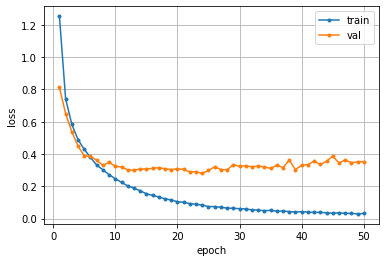

In [31]:
plot_history_train_val(history, 'loss')

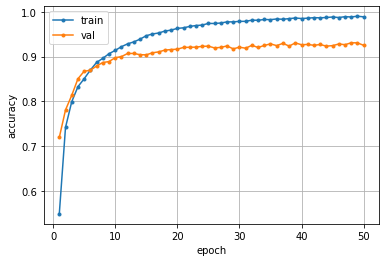

In [32]:
plot_history_train_val(history, 'accuracy')